# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline. 
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
# dest_path='./data/features.csv')
# gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
# dest_path='./data/im/nevus-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
# dest_path='./data/im/nevus.jpg')
# gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
# dest_path='./data/im/melanoma-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
# dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [3]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

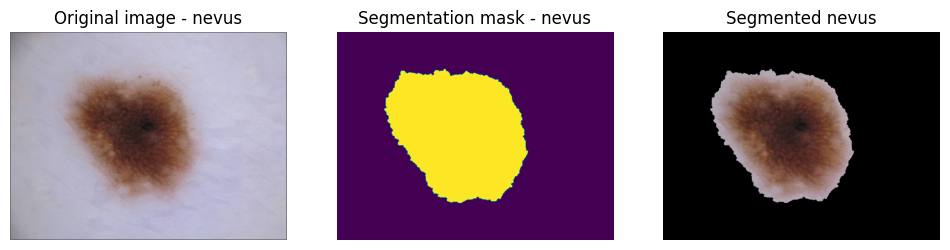

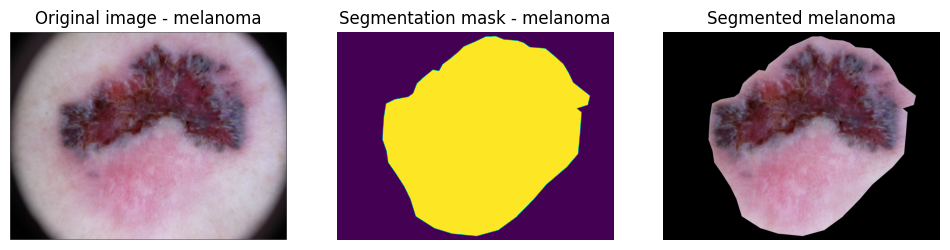

In [4]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [5]:
# Shuffle data randomly
indices = np.arange(N)
np.random.shuffle(indices)
Xp=X[indices]
yp=y[indices]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

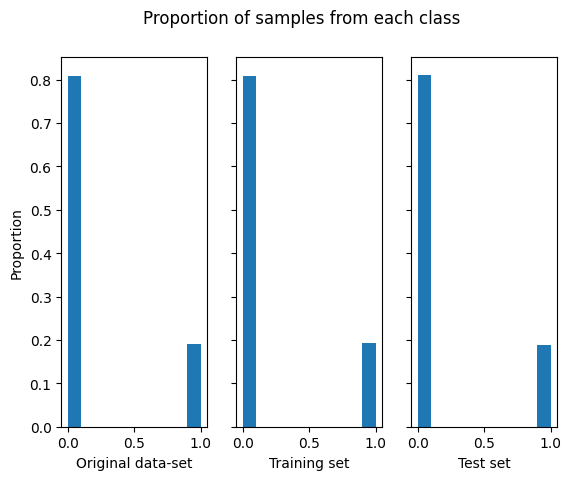

In [6]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)
    
fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

In [7]:
# Scale data (each feature will have average equal to 0 and unit variance)
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

**Answer**:  
D'après les matrices, les modèles auront tendance à presque tout classifier comme lésion saine.

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       146
           1       0.26      0.15      0.19        34

    accuracy                           0.76       180
   macro avg       0.54      0.53      0.52       180
weighted avg       0.71      0.76      0.73       180

Normalized confusion matrix
[[0.90410959 0.09589041]
 [0.85294118 0.14705882]]


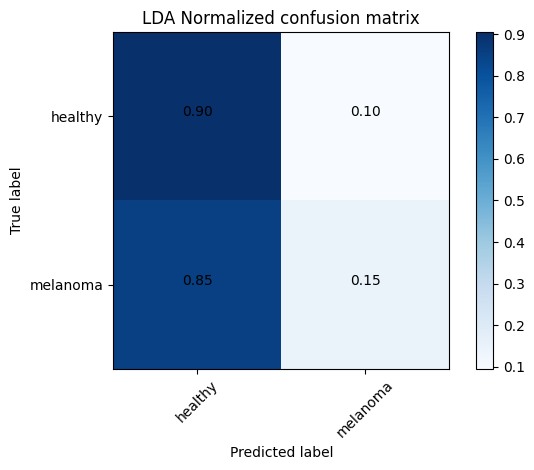

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       146
           1       0.25      0.15      0.19        34

    accuracy                           0.76       180
   macro avg       0.53      0.52      0.52       180
weighted avg       0.71      0.76      0.73       180

Normalized confusion matrix
[[0.89726027 0.10273973]
 [0.85294118 0.14705882]]


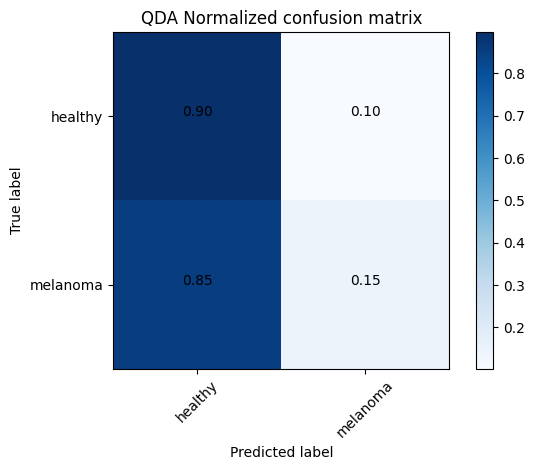

In [10]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

On peut utiliser _GridSearchCV_ pour avoir un résultat moins biaisé.

Fitting LDA
Normalized confusion matrix
[[0.90410959 0.09589041]
 [0.85294118 0.14705882]]


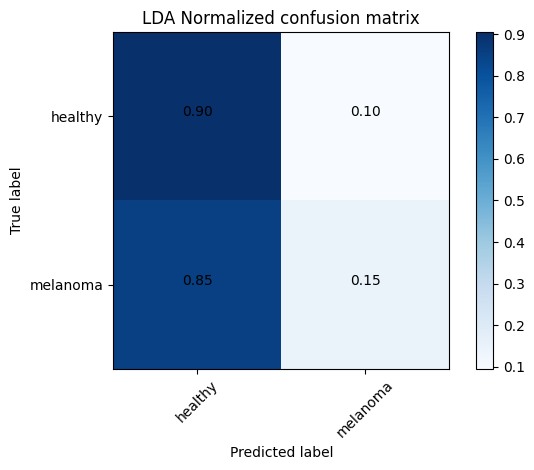

Fitting QDA
Normalized confusion matrix
[[0.89726027 0.10273973]
 [0.85294118 0.14705882]]


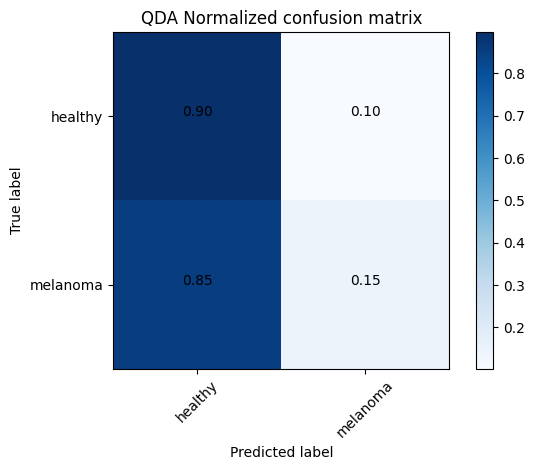

Fitting K-nearest neighbour
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.94117647 0.05882353]]


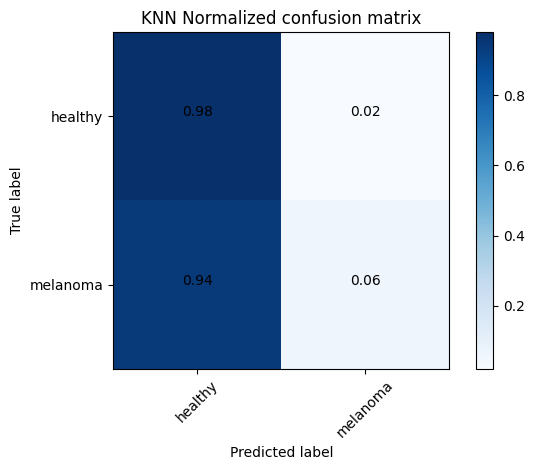

In [12]:
# Fitting LDA
print("Fitting LDA")
clf_lda = LinearDiscriminantAnalysis()
grid_lda = GridSearchCV(clf_lda,{})
grid_lda.fit(X_train_scale,y_train)

lda_star = grid_lda.best_estimator_
y_pred = lda_star.predict(X_test_scale)

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='LDA Normalized confusion matrix')
plt.show()
# Fitting QDA
print("Fitting QDA")
clf_qda = QuadraticDiscriminantAnalysis()
grid_qda = GridSearchCV(clf_qda,{})
grid_qda.fit(X_train_scale,y_train)

qda_star = grid_qda.best_estimator_
y_pred = qda_star.predict(X_test_scale)

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='QDA Normalized confusion matrix')
plt.show()

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
clf_knn = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
grid_knn = GridSearchCV(clf_knn,parameters)
grid_knn.fit(X_train_scale,y_train)

knn_star = grid_knn.best_estimator_
y_pred = knn_star.predict(X_test_scale)

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='KNN Normalized confusion matrix')
plt.show()

---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. 

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

**Answer**: Le modèle a à nouveau tendance à tout classer comme lésion saine. Cela peut venir du fait que le dataset comporte une grande majorité de lésions saines relativement aux mélanomes.

---

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8261904761904761
Best training params: {'kneighborsclassifier__n_neighbors': 10}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.94117647 0.05882353]]


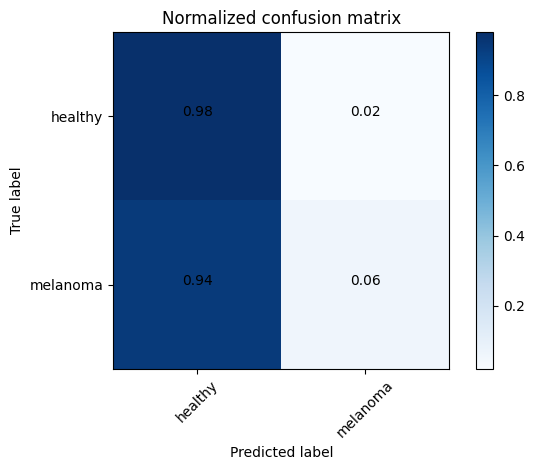

In [14]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train_scale, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test_scale)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.6402216856892011
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.73529412 0.26470588]]


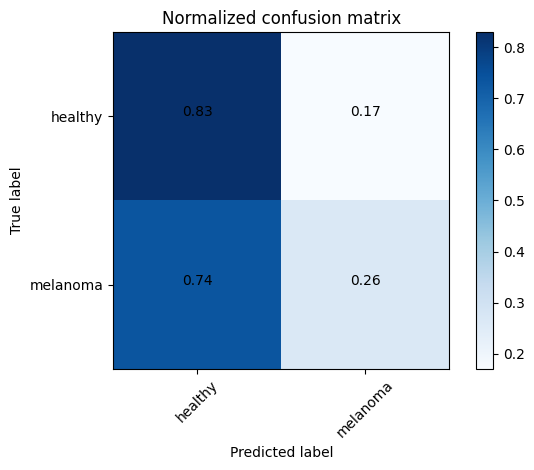

In [15]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_train_scale, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test_scale)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage. 

In [20]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_scale, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 341)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?  

**Answer**: Les résultats sont meilleurs, comme le montre l'augmentation significative du score ou la *confusion_matrix*. De plus, on n'observe plus de différence entre "accuracy" et "balanced_accuracy" puisque les classes sont équilibrées.

Best training Score: 0.8879932180529577
Best training params: {'n_neighbors': 2}
Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.61764706 0.38235294]]


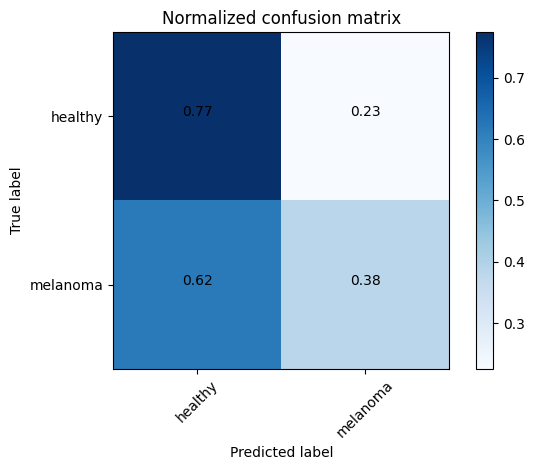

In [21]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test_scale)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [22]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7629166666666667 +- 0.009354143466934872
 Average and std TEST CV accuracy : 0.7266666666666667 +- 0.014337208778404362
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8429166666666668 +- 0.005034602488997721
 Average and std TEST CV accuracy : 0.8133333333333335 +- 0.01715938356831167


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [23]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7629166666666667 +- 0.009354143466934872
 Average and std TEST CV accuracy : 0.7266666666666667 +- 0.014337208778404362
 Average and std TRAIN CV f1 : 0.39057503745188693 +- 0.019575228996956996
 Average and std TEST CV f1 : 0.2988241073347456 +- 0.07509652853382102
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8433333333333334 +- 0.005170697352496172
 Average and std TEST CV accuracy : 0.8150000000000001 +- 0.016996731711975955
 Average and std TRAIN CV f1 : 0.42250972580996543 +- 0.02935592213767627
 Average and std TEST CV f1 : 0.3101043643263758 +- 0.06517616559723255


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


In [24]:
from imblearn.pipeline import make_pipeline as make_pipeline2 

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM
print("Fitting Linear SVM")
svm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
svm_cv = cross_validate(svm,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(svm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(svm_cv['train_accuracy'].mean(), svm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(svm_cv['test_accuracy'].mean(), svm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(svm_cv['train_f1'].mean(), svm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(svm_cv['test_f1'].mean(), svm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7108333333333333 +- 0.056494837522261
 Average and std TEST CV accuracy : 0.6783333333333335 +- 0.03480102169636849
 Average and std TRAIN CV f1 : 0.46819023569023577 +- 0.03034551361720458
 Average and std TEST CV f1 : 0.37951107715813603 +- 0.06557143222995816
Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.755 +- 0.008079466429027229
 Average and std TEST CV accuracy : 0.7050000000000001 +- 0.040688518719112346
 Average and std TRAIN CV f1 : 0.5225210575524581 +- 0.018509913389699165
 Average and std TEST CV f1 : 0.418770297390987 +- 0.07504510334080587


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.713095238095238 +- 0.0416921690662797
 Average and std TEST CV accuracy : 0.6976190476190476 +- 0.040963453652583935
 Average and std TRAIN CV f1 : 0.48310347960903366 +- 0.04313014607231906
 Average and std TEST CV f1 : 0.45621489402085047 +- 0.03775220741427867
Normalized confusion matrix
[[0.67123288 0.32876712]
 [0.5        0.5       ]]


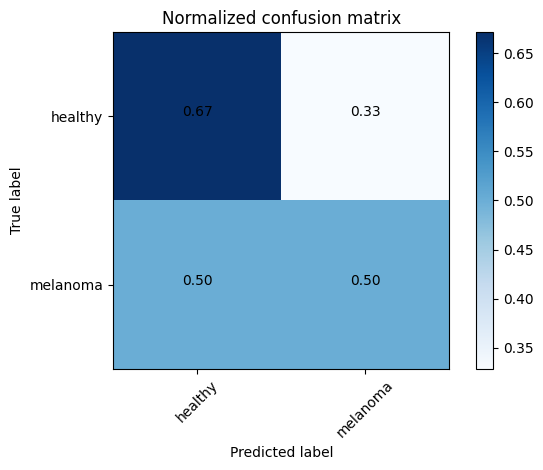

Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.713095238095238 +- 0.0416921690662797
 Average and std TEST CV accuracy : 0.6976190476190476 +- 0.040963453652583935
 Average and std TRAIN CV f1 : 0.48310347960903366 +- 0.04313014607231906
 Average and std TEST CV f1 : 0.45621489402085047 +- 0.03775220741427867
Normalized confusion matrix
[[0.67123288 0.32876712]
 [0.5        0.5       ]]


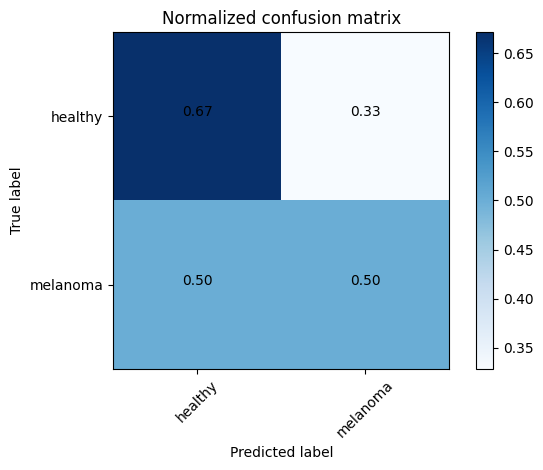

In [25]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train_scale, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test_scale)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM 
print("Fitting Linear SVM")
svm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
svm_cv = cross_validate(Perc,X_train_scale, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(svm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(svm_cv['train_accuracy'].mean(), svm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(svm_cv['test_accuracy'].mean(), svm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(svm_cv['train_f1'].mean(), svm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(svm_cv['test_f1'].mean(), svm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(svm_cv['test_accuracy'])
estimator_best=svm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test_scale)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7547619047619047
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.52941176 0.47058824]]


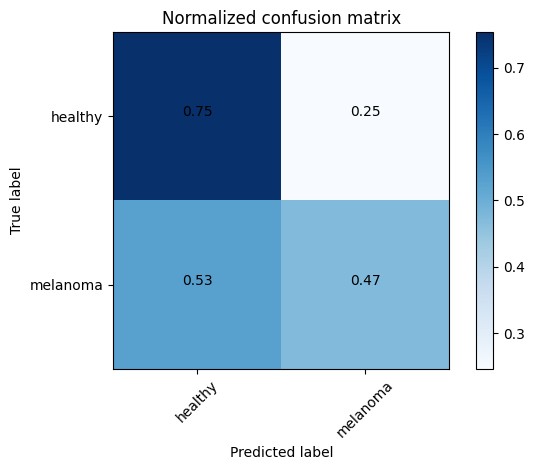

In [30]:
# Looking for the best hyperparameter C 
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator = Lsvm, param_grid = p_grid_lsvm, cv = 5)
grid_lsvm.fit(X_train_scale,y_train)
best_estimator = grid_lsvm.best_estimator_
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = best_estimator.predict(X_test_scale)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8238095238095239
Best training params: {'svc__C': 1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.93150685 0.06849315]
 [0.88235294 0.11764706]]


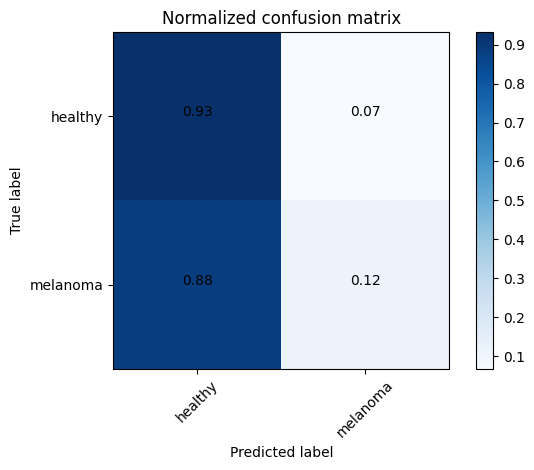

In [31]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=5)
grid_nlsvm.fit(X_train_scale,y_train)
best_estimator = grid_nlsvm.best_estimator_
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = best_estimator.predict(X_test_scale)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer**: La méthode à privilégier serait la SVM avec données linéaires, en rééchantillonant les données, puisque c'est celle qui limite les cas où des mélanomes sont pris pour de la peau saine. Il est en effet préférable de classer trop de mélanomes en tant que tels, plutôt que pas assez.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# Test PCA with a linear SVM
XXXXXXXX

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

XXXXXXXXXXXXXXXX

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

XXXXXXXXXX